# Robust Multi-array Average (RMA)

(<i>Microarray pre-processing techniques in Python</i>)

## Introduction

Pre-processing methods in biological data analysis are one of the most important part of the analysis itself, because it should be done in a way in which the real data information would not be lost, while the noise and measurement errors must be cleaned out.
Obviously it is not trivial to separate in an efficient yet reliable way data and noise, especially in dealing with biological data: measurements errors are very likely to be done at each step in the extraction of numeric data from the biological liquid which gene expression measurements come from.
<i>Microarray</i> is a famous and very used techniques to measure gene expression data. Maybe it is a bit overcome, but microarray data can be easily used to perform analysis onto, while other methodologies are currently under development.
Only for microarrays there are several preprocessing techniques (RMA, GCRMA, MAS5, etc.) which perform better or poorer: the aim of this project is to analyse another way to pre-process biological microarray data in order to obtain clean data that can be used for further data mining steps.

All the microarray analysis are traditionally performed with the R programming language, perhaps due to his better performance in this field, but this time the analysis are done in Python for its simplicity and versatility.

## 1. Loading files

The first step in the data analysis is obviously file loading. Microarray expression intensities are saved into .CEL files; the function <code>rd.load_files()</code> is used to load all the .CEL files under the specified directory (the default is "./CEL_files/") and store them into a variable.
This function is based on a function of the <code>biopython</code> package, a package in python which provides some useful function for dealing with biological data (even if this is the only which is going be used in this project).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

import rma
import celfile as rd
import rmaplot as rplt

cels, files = rd.load_files()

Loading files ...
Loading chip  1 of 20
Loading chip  2 of 20
Loading chip  3 of 20
Loading chip  4 of 20
Loading chip  5 of 20
Loading chip  6 of 20
Loading chip  7 of 20
Loading chip  8 of 20
Loading chip  9 of 20
Loading chip 10 of 20
Loading chip 11 of 20
Loading chip 12 of 20
Loading chip 13 of 20
Loading chip 14 of 20
Loading chip 15 of 20
Loading chip 16 of 20
Loading chip 17 of 20
Loading chip 18 of 20
Loading chip 19 of 20
Loading chip 20 of 20
	... done.


The <code>cels</code> variable contains a list of Records, that are classes useful to manipulate .CEL files. A .CEL file represents an Affymetrix microarray, and most of all it contains the calculated intensities for each probe. To pass from a list of records to a matrix that can be easily manipulated, it can be simply created a matrix from the PM (Perfect Match) intensities of records.
The output matrix would be produced putting each GeneChips as a different column, while each row is formed by the (flatten) intensities of the chip, each one is a probe.

<code>rd.load_files()</code> also produces a list of strings, namely the files that are read by the function, which will be useful (and used) later.

Next, the first thing to do with the loaded files is a log scaling of PM intensities, previously stored in a 2-dimensional array.

In [2]:
###
### PM Matrix
### rows are probes, columns are GeneChips
###
PM = np.log(np.array([c.intensities.flatten() for c in cels]).T)

A very important part in pre-processing analysis is data visualisation. In the shown code it is used <code>seaborn</code> as a very intuitive and useful package to visualise data in Python: it is a plotting package based on <code>matplotlib</code>, but it provides a great choice of colours and plot types.
Data are stored in a <code>PM</code> matrix, which for now contains unprocessed data; it can be used in order to produce the first plot of biological data which will be processed later.

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:476: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


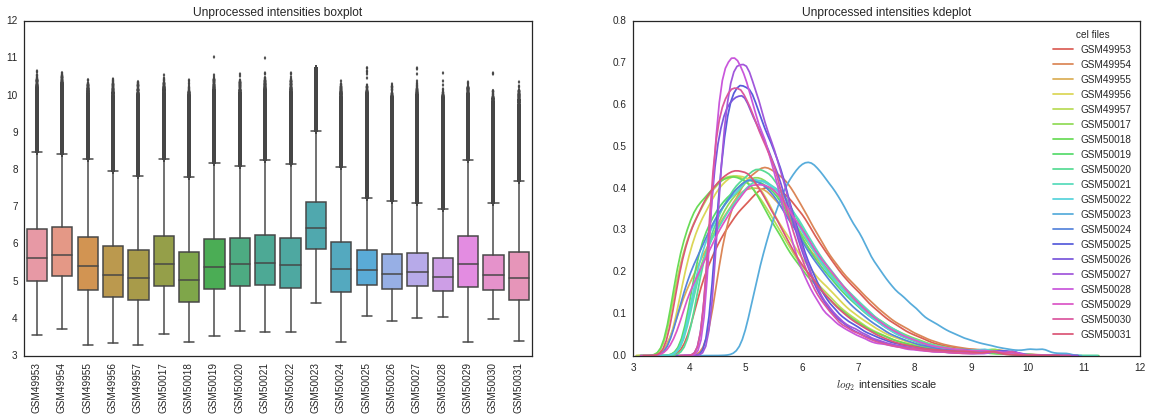

In [3]:
###
### Get unprocessed intensities and boxplot them
###
plt.figure(figsize=(20, 6))
plt.subplot(121)
sns.boxplot(PM, names=files)
plt.xticks(rotation=90)
plt.legend()
plt.title("Unprocessed intensities boxplot")

###
### Histograms of unprocessed intensities for the loaded files
###
plt.subplot(122)
rplt.histmult(PM,files=files)
plt.title("Unprocessed intensities kdeplot")
plt.show()

These plots represent the calculated distributions of chip (unprocessed) intensities, each one in a different colour. The first one is a "boxplot", in which each box is a distribution (seen "<i>from the high</i>") where the black segment is the highest value. The second plot is built with a <code>seaborn</code> function, namely <code>kdeplot</code>, which shows a continuous approximation of intensities histograms, that is a <i>fit line</i>. The resulting plot is obtained putting all the intensities distributions in the same plot, in order to clearly see their difference.

It will be useful to analyse differences between these plots and the ones built from intensities after background correction and normalisation; these differences are visible, and they will be shown later.

## 2. Background correction

In biological data the signal that has to be analysed it is sorrounded by noise that instead has to be removed.
RMA is composed by a series of steps to be performed to clean out noise from the real signal. They are:
- background correction
- normalisation
- summarisation

<i>Background correction</i> is the first step that has to be performed on the input intensities, to remove all the intensities which are not part of the real signal. This step is fundamental because unprocessed intensities are never zero, due to the techniques used to colour the microarray chip, even if the intensity extracted is not part of the signal, but it is only noise of the background.

The observed PM intensities for any probe on an array is assumed to be composed by a signal and a noise component, so that the observed intensity $Y$ is given by

$$Y = S+N$$

as the sum of signal $S$ and noise $N$. It is assumed that $S$ follows an exponential distibution with parameter $\alpha$, while $N$ is distributed normally (truncated at 0 to avoid negatives) with mean $\mu$ and variance $\sigma^2$.
The background-corrected value it is then calculated as

$$E(s|Y=y)=a+b\frac{\phi(\frac{a}{b}) - \phi(\frac{y-a}{b})}{\Phi(\frac{a}{b}) + \Phi(\frac{y-a}{b}) - 1}$$

where $a = y-\mu -\sigma^2\alpha$ and $b=\sigma$. In practice the second term on the numerator and on the denominator are 0 and 1, respectively, so the formula is simplified. 

In the code, all RMA correction signal steps are put into the <code>rma.py</code> file, that is imported in the main file of the analysis. The following is the main background correction function, that has to be called to perform the background correction.

In [4]:
### [defined in rma.py] ###
def bg_parameters(PM):
    PMmax = max_density(PM)
    PMn = PM[PM < PMmax]

    PMmax = max_density(PMn)
    sd = get_sd(PM, PMmax)

    PMn = PM[PM > PMmax]
    alpha = get_alpha(PMn, PMmax)

    return alpha, PMmax, sd

def bg_correction(X):
    print("RMA background correction ...")
    X_corrected = []
    for i in range(X.shape[1]):
        print("Chip n. %2i/%i" % (i+1, X.shape[1]))
        v = X[:,i]
        alpha, PMmax, sd = bg_parameters(v)
        a = v - PMmax - alpha * (sd ** 2)
        PMn = a + sd * phi(a/sd) / Phi(a/sd)
        if np.isnan(np.sum(PMn)):
            print("NaN found. Something is wrong. Chip %i is skipped." % i)
            continue
        X_corrected.append(np.array(PMn))

    print("\t... done.")
    return np.array(X_corrected).T

The principal task of this function is to estimate the three parameters $\alpha$, $\mu$ and $\sigma$. $\mu$ is what in the code is called "PMmax", and it is found by removing all the intensities higher than the value that has the most concentration (found by the function <code>max_density()</code>) and then recalculate the value with has the second most concentration. With this it is possible also to estimate the value of $\sigma$, taking left intensities and assuming they are the noise.

The function <code>max_density()</code> is implemented with two modalities: 'fast' and 'default'. The mode in which the previous and the following code is run is 'fast', which simply returns the median of the input values. 
The second mode is more accurate: a Gaussian distribution is fitted over the data, and the value which produce the highest values on the Gaussian function is returned. However this mode was really too expensive from a computational point of view, and so it was optimised with a "more discrete" approximation, that is, taken a <code>np.linspace()</code> of $N$ values ($N << len(X)$, $X$ input data) in the range of the input data, the one which produced the highest value in the Gaussian fitted over all the data was the winner. This is again an approximation; tests on data have confirmed that this is only really slighly better than the more efficient median over input data, and so the code is run only with 'fast' mode (but 'default' mode was not deleted, for the sake of completeness).

$\sigma$ is then calculated with the two PM values which produce the highest values in the gaussian distributions that are fitted on the data, considering the left side of PM intensities. This can be seen running the simple following code, which shows the two highest values in data distributions with which $\sigma$ is calculated.

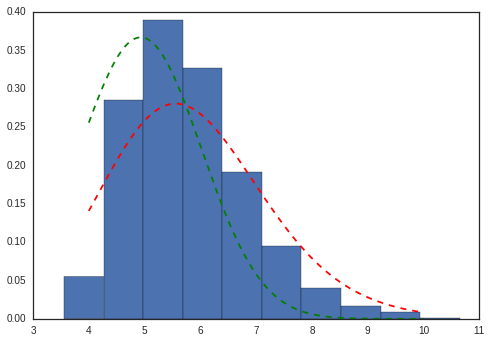

In [32]:
from sklearn.neighbors.kde import KernelDensity
X = PM[:,0]
kde = KernelDensity(kernel='gaussian').fit(X[:,np.newaxis])
xaxis = np.linspace(4,10,150)[:,np.newaxis]
gauss = kde.score_samples(xaxis)
PMmax = xaxis[np.argmax(np.exp(gauss))][0]
PMn = X[X < PMmax]

kde = KernelDensity(kernel='gaussian').fit(PMn[:,np.newaxis])
gauss2 = kde.score_samples(xaxis)

plt.figure()
plt.hist(X, normed=True)
plt.plot(xaxis, np.exp(gauss),'--r')
plt.plot(xaxis, np.exp(gauss2),'--g')
plt.show()

Instead, signal distribution parameter $\alpha$ is estimated taking the right part of PM data. The formula used is the maximum likelihood for the rate parameter, that is:

$$\alpha=\frac{1}{\hat{x}}$$

where $\hat{x}$ is calculated as the <i>max density</i> of the PM intensities higher than the PMmax intensity (so that the fit line on the intensities higher than the median value produce a negative exponential, intrpreted as the signal of which the parameter $\alpha$ is estimated).

The results can be shown running all the background-correction code over the PM matrix and plotting the results.

RMA background correction ...
Chip n.  1/20
Chip n.  2/20
Chip n.  3/20
Chip n.  4/20
Chip n.  5/20
Chip n.  6/20
Chip n.  7/20
Chip n.  8/20
Chip n.  9/20
Chip n. 10/20
Chip n. 11/20
Chip n. 12/20
Chip n. 13/20
Chip n. 14/20
Chip n. 15/20
Chip n. 16/20
Chip n. 17/20
Chip n. 18/20
Chip n. 19/20
Chip n. 20/20
	... done.


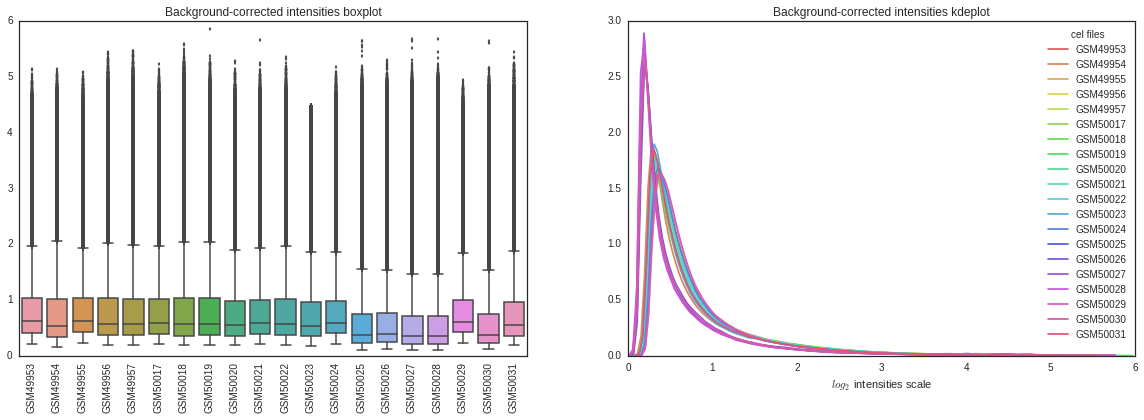

In [5]:
###
### Boxplot background-corrected values
###
PM_corrected = rma.bg_correction(PM)

plt.figure(figsize=(20, 6))
plt.subplot(121)
sns.boxplot(PM_corrected, names=files)
plt.xticks(rotation=90)
plt.ylim(0,6)
plt.legend()
plt.title("Background-corrected intensities boxplot")

###
### Histograms of background-corrected values
###
plt.subplot(122)
rplt.histmult(PM_corrected,files=files)
plt.title("Background-corrected intensities kdeplot")
plt.show()

Background correction is used to remove noise from intensities values; resulting values are now in a more or less comparable way (but not yet perfectly comparable) as it can be seen from last plots. The aim is to normalise these data in order to put all the intensities with comparable values; the idea behind this is that all of these values come from the same distribution, and so it is possible to have similar values (for example with a common mean: more in general with similar parameters of the same distribution).

Unlike the initial plots, these last two plot have almost the same centre value: the value which produces the highest values in all distributions is always around 0.5 in the $log_2$ intensities scale. This is a good information, because from that it can be seen how this is the right way to process these types of data.

## 3. Normalisation

The next step in RMA data pre-processing is a normalisation step. Data are background-corrected, but now they should be put in a way to be really comparable: in RMA normalisation is done by <i>quantile normalisation</i>; the goal of quantile normalisation is to give the same distribution of intensities to each array. An intensity is transformed in quantile normalisation with the following formula:

$$x^*_{ij} = F^{-1}(G_j(x_{ij}))$$

where $x_{ij}$ is measurement $i$ on array $j$, $G_j$ is the distribution function for array $j$ and $F^{-1}$ is the inverse of the distribution function to be normalised to; the normalised intensity thus is given by $x^*_{ij}$.

As described in Bolstad et al. (2003), quantile normalisation is obtained in practice with the following steps:
1. Given $n$ arrays (GeneChips) of length $p$, form $X$ of dimension $p\times n$ where each array is a column;
2. Sort each column of $X$ to give $X_{sort}$;
3. Take the means across rows of $X_{sort}$ and assign this mean to each element in the row to get $X'_{sort}$;
4. Get $X_{normalised}$ by rearranging each column of $X'_{sort}$ to have the same ordering as original $X$.

Thus $X_{normalised}$ contains normalised values with the same order as the ones in the original matrix $X$ of unprocessed intensities (the one that was called PM).

In this way the new matrix will have all values normalised: highest values in the columns are now equal, the same for second highest values, and so on. In the code it is implemented in the following manner:

In [16]:
### [defined in rma.py] ###
def qnormalize(X):
    ''' X matrix with samples in the columns and probes across the rows. '''
    print("Quantile normalization ...")
    A   = np.array(X)
    AA  = np.zeros_like(A, dtype=np.float)
    I   = np.argsort(A, axis=0)
    Ord = A[I,np.arange(A.shape[1])]  # ordered matrix by column
    AA[I,np.arange(A.shape[1])] = np.mean(Ord,axis=1)[:,np.newaxis]
    print("\t... done.")
    return AA

Again, results of this pre-processing step can be at least visually evaluated by plotting the results with box-plots and kde-plots, as seen before.

Quantile normalization ...
	... done.


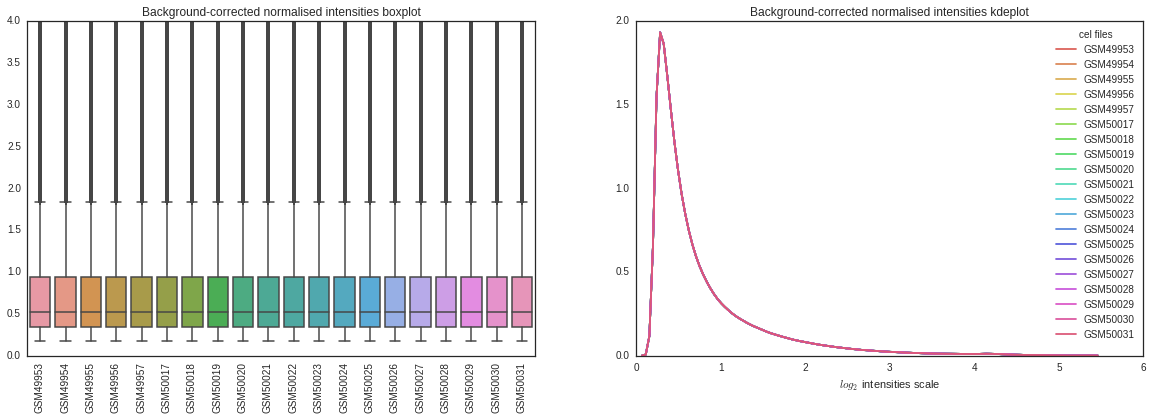

In [6]:
###
### Quantile normalisation (works the same as R)
###
PM_normalised = rma.qnormalize(PM_corrected)

plt.figure(figsize=(20, 6))
plt.subplot(121)
sns.boxplot(PM_normalised, names=files)
plt.xticks(rotation=90)
plt.ylim(0,4)
plt.legend()
plt.title("Background-corrected normalised intensities boxplot")

###
### Histograms of normalised intensities
###
plt.subplot(122)
rplt.histmult(PM_normalised,files=files)
plt.title("Background-corrected normalised intensities kdeplot")
plt.show()

Here it can be seen as normalisation works: now kde-plots of all the intensities between GeneChips are almost the same, and so their plot overlap. In the left plot there are the same distributions and they are all aligned. Signal at this point is background-corrected and normalised, and plots of each chip produce almost the same distribution.

Relevant is also the shape of normalised signal: it is almost an exponential distribution as it was assumed to be, without noise that has been removed well.

At this point an interesting comparison can be the one with the quantile normalisation of R. In Python, R code can be imported using a Python package, "<code>RPy2</code>", which allows to execute R functions inside Python code.
The R function works with R matrix, so input must be reconstructed before the function call.

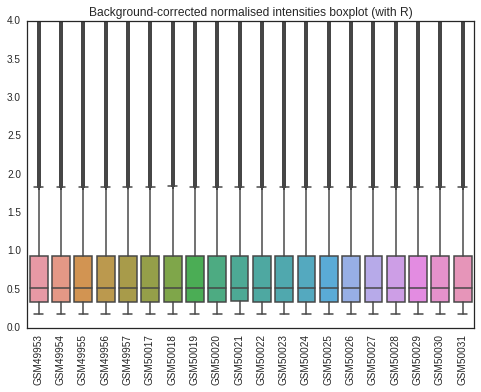

Difference norm: 0.000412


In [34]:
###
### R quantile normalisation
###
import rpy2.robjects as robjects

# Reconstructing the matrix ...
v = [PM_corrected[:,i].tolist() for i in range(PM_corrected.shape[1])]
v = [item for sublist in v for item in sublist]
m = robjects.r['matrix'](robjects.FloatVector(v), nrow = PM_corrected.shape[0])
robjects.r('require("preprocessCore")')
norm_a = np.array(robjects.r('normalize.quantiles')(m))

plt.figure()
sns.boxplot(norm_a, names=files)
plt.xticks(rotation=90)
plt.ylim(0,4)
plt.legend()
plt.title("Background-corrected normalised intensities boxplot (with R)")
plt.show()
print("Difference norm: %f" % (np.linalg.norm(norm_a - PM_normalised) / np.linalg.norm(PM_normalised)))

The boxplot of intensities after the quantile normalisation is almost the same as before. The relative difference between the calculated intensities is actually 0.000412: of the order of $10^{-4}$ it is pretty negligible, so it can be concluded that the quantile normalisation purely implemented in Python works well, like the one implemented in R.

## 4. Summarisation

Last step in the pipeline of biological data pre-processing with RMA technique is the summarisation. This step is needed because of the microarray geometry: each row is a probe, but in each microarray multiple probes are measuring the same portion of RNA (in order to obtain reliable measurements) so at this time the aim is to average rows (probes) which measured the same RNA pieces.

RMA expression measure is actually based upon fitting the model

$$y_{kij} = \beta_{kj}+\alpha_{ki}+\epsilon_{kij}$$

where the indices $k$, $j$ and $i$ refer to probe set, chip and probe, respectively; $y_{kij}$ is the response term ($log_2$ transformed, background-corrected and normalised PM intensity), $\beta_{kj}$ and $\alpha_{ki}$ are the chip effect and probe effect, and $\epsilon_{kij}$ is the error term. From this model it can be seen how at this point from a probes-chips matrix it should be obtain a <i>probe sets</i>-chips matrix, in order to put together probes which measure the same RNA pieces.

Actually this step is left to the reader, as it does not involve signal manipulation and normalisation. In order to perform this last step it would be required the geometry of the GeneChips used, namely HG-133A; then rows which correspond to the same probe set must be averaged in order to produce a single intensity value for each probe set. In this way a final reliable matrix with the corrected intensities is produced.

Then, as the last step of the pipeline of RMA, has to be implemented for RMA another function to finalise the output matrix: that is the <i>median polish</i>.

With this function it is built a residuals matrix removed from the probe set matrix obtained, which completes the pipeline of RMA.

In [9]:
### [defined in rma.py] ###
def medianpolish(X):
    ''' The idea is to estimate the errors by “median polishing” and
    then subtract the estimated errors to obtain adjusted
    probe summaries'''

    print("Median polishing ...")
    R = X  # the aim is to build a residuals matrix
    maxiter = 10
    eps = 0.01
    oldsum, s = 0.0, 0.0

    for iter in range(maxiter):
        m = np.median(R, axis=0)
        R = np.array([R[:,i] - m[i] for i in range(len(m))]).T

        m = np.median(R, axis=1)
        R = np.array([R[i,:] - m[i] for i in range(len(m))])
        s = np.sum(R)
        if s == 0.0 or np.abs(1.0 - oldsum/s) < eps:
            break
        oldsum = s
    print("\t... done.")
    return X - R

In the code there is not a building of a probe set matrix, so the function is tested with all input data (as each probe set would contain just a single probe). Thus, median polishing the probes-chips PM matrix, a new matrix is produced, where it is produced by a difference between the initial matrix $X$ and a residual matrix $R$, produced from an iterative algorithm.

Median polishing ...
	... done.


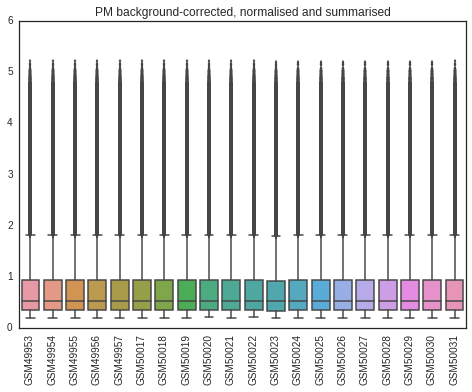

In [36]:
###
### Summarisation: median polish
###
PM_summarised = rma.medianpolish(PM_normalised)
plt.figure()
sns.boxplot(PM_summarised, names=files)
plt.xticks(rotation=90)
#plt.ylim(0,6)
plt.legend()
plt.title("PM background-corrected, normalised and summarised")
plt.show()

The new matrix after the median polish algorithm actually looks like the one before, because the input matrix of RMA median polish should not be a probes-chips matrix, but a <i>probe sets</i>-chips matrix, which would give a different and a really final result. Having already normalise the same data in the previous step the output is practically the same as before; but this step becomes very important working with the probe set-chips matrix.

## Conclusions 

Variable <code>PM_summarised</code> contains the matrix with processed intensities, which can be used for further data analysis.

As said before, a very important task in all data pre-processing steps is data visualisation, which gives visual feedback of what is being done with data (that are signals, actually). For this reason it is possible and strongly advised to show the intensities which have been processed until now, for a visual feedback of results obtained.

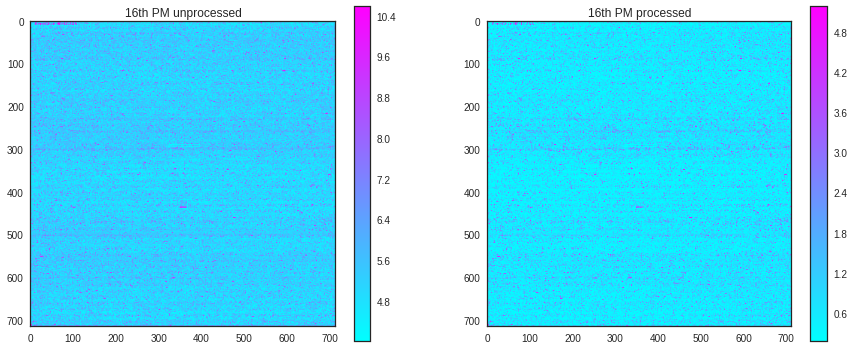

In [37]:
###
### Difference between an unprocessed and a processed GeneChip
###
plt.set_cmap('cool')
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(np.reshape(PM[:,16], (712,712)))
plt.colorbar()
plt.title("16th PM unprocessed")
plt.subplot(122)
plt.imshow(np.reshape(PM_summarised[:,16], (712,712)))
plt.colorbar()
plt.title("16th PM processed")
plt.show()

Even if the images are small it can be felt how the second image has more contrast, while values are in a range nearer 0. This is a good result, as it can be expected that many of the intensities must have very small values, as not all genes can be active. High values as the ones found in unprocessed intensities were caused by background that is noise. RMA correction can improve these data, reducing noise from the signal; new intensities can in this way be efficiently used for next analysis.

Another important plots which are designed in microarray normalisation analysis are the so-called <i>MA-plots</i>.
A MA-plot is a visual representation of two channel DNA microarray gene expression data which has been transformed onto the $M$ (log ratios) and $A$ (mean average) scale.
$M$ and $A$ are defined by the following equations:

$$M = log_2(R) - log_2(G)$$
$$A = \frac{1}{2}(log_2(R)+log_2(G))$$

where $R$ (Red) and $G$ (Green) are the two channel of the microarray to be compared. In a single-channel microarray there is not such intensities difference: thus MA-plot in RMA single-channel microarray analysis are built from intensities of a single GeneChip in contrast to a pseudo-median reference GeneChip, built from the median of each rows (for this reason it is a pseudo-median: this chip does not exists as a single column, but is build from the median of each row).

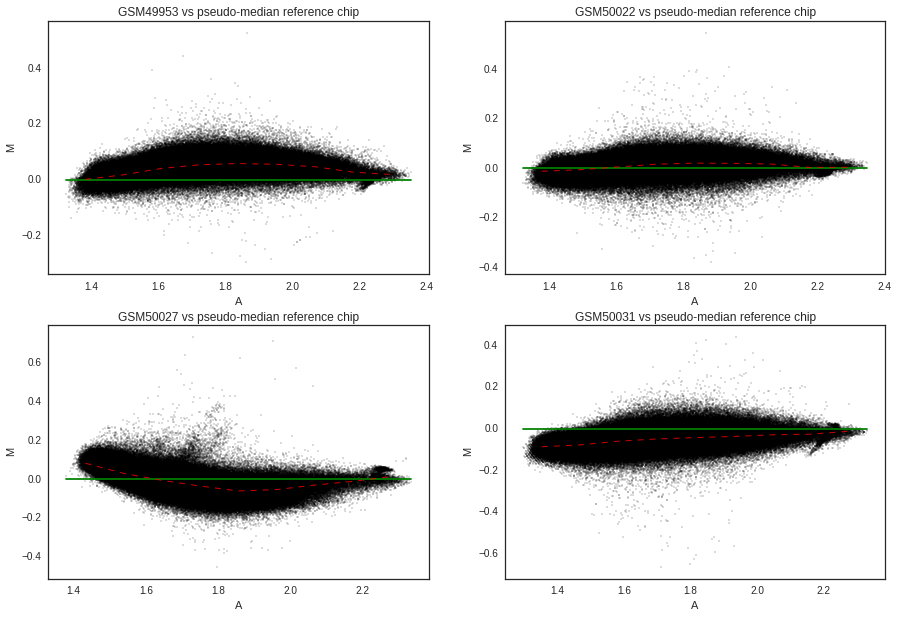

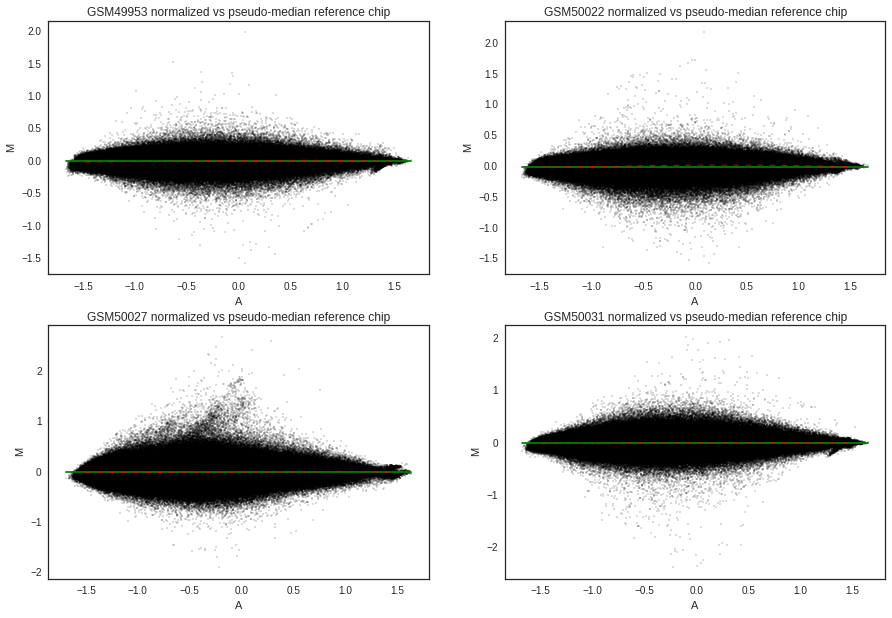

In [38]:
### [defined in rmaplot.py] ###
def maplot(R, G):
    ''' Draw 2D MA-plots for RMA microarray processing.

        Input (for RMA):

        R: first chip to compare (pseudo Red channel)
        G: pseudo-median reference chip (pseudo Green channel)

        Returns:

        A, M: x- and y-components from the plot.
        xline, yline: component of the regression line

        Usage example:

        M, A, xline, yline = maplot(PM[:,0], np.median(PM, axis=1))
        plt.figure()
        plt.scatter(A,M,color='k',alpha=.2,s=2)
        plt.plot(xline,yline,'r--',lw=1,alpha=.8)
        plt.axis('tight')
        plt.show()

        '''
    M = np.log(R) - np.log(G)
    A = .5 * (np.log(R) + np.log(G))

    bins = np.linspace(A.min(),A.max(), 10)
    delta = bins[1]-bins[0]
    idx  = np.digitize(A,bins)
    running_median = [np.median(M[idx==k]) for k in range(10)]
    xline, yline = bins-delta/2, running_median
    return M, A, xline, yline

###
### MA-plots
###
plt.figure(figsize=(15, 10))
for s, i in zip(range(221,225), [0,10,15,19]):
    plt.subplot(s)
    M, A, xline, yline = rplt.maplot(PM[:,i], np.median(PM, axis=1))
    plt.scatter(A,M,color='k',alpha=.2,s=2)
    plt.plot((A.min(), A.max()), (0, 0), 'g')
    plt.plot(xline,yline,'r--',lw=1,alpha=.8)
    plt.axis('tight')
    plt.xlabel('A'); plt.ylabel('M')
    plt.title(files[i]+' vs pseudo-median reference chip')
plt.show()

plt.figure(figsize=(15, 10))
for s, i in zip(range(221,225), [0,10,15,19]):
    plt.subplot(s)
    M, A, xline, yline = rplt.maplot(PM_normalised[:,i], np.median(PM_normalised, axis=1))
    plt.scatter(A,M,color='k',alpha=.2,s=2)
    plt.plot((A.min(), A.max()), (0, 0), 'g')
    plt.plot(xline,yline,'r--',lw=1,alpha=.8)
    plt.axis('tight')
    plt.xlabel('A'); plt.ylabel('M')
    plt.title(files[i]+' normalized vs pseudo-median reference chip')
plt.show()

These plots are very useful to evaluate benefits of data normalisation; each image contains 4 figures, in which a random GeneChip is compared to the pseudo-median chip, before and after the processing. Each one of the first 4 figures have the median value not aligned with the plot centre; normalisation produces good outputs because the median across y-axis (that is the difference between the logarithms of the two channels) is zero, as it can be seen from the overlapping of the green line (a constant zero line) and the red line (built from the median of points).

RMA is a very powerful and relative easy way to pre-process biological data. Usually these analysis are performed in other programming languages (as R), while the real implementation of functions is actually in C, because is computationally more efficient. The aim of this project was to analyse unprocessed biological data using Python for its simplicity, implementing a common pre-processing algorithm (RMA) in this programming language. The results are really interesting, even if a C-implementation of actual functions would surely result in a more efficient RMA implementation.